## 1. 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [3]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2. 데이터로더 구성

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

In [7]:
# -----------------여기서부터 분석파트 -----------------

print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [8]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
# word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4]) 

<BOS>
1909
.


In [9]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
import numpy as np
import tensorflow as tf
import os

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 4. 모델 구성 및 validation set 구성
## 5. 모델 훈련 개시
## 6. Loss, Accuracy 그래프 시각화

In [12]:
X_val = X_train[:30000]
y_val = y_train[:30000]
X_train = X_train[30000:]
y_train = y_train[30000:]

In [13]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 21s 8ms/step - loss: 0.5597 - accuracy: 0.7446 - val_loss: 0.4392 - val_accuracy: 0.8403
Epoch 2/5
227/227 [==============================] - 1s 5ms/step - loss: 0.3771 - accuracy: 0.8509 - val_loss: 0.3572 - val_accuracy: 0.8489
Epoch 3/5
227/227 [==============================] - 1s 5ms/step - loss: 0.3254 - accuracy: 0.8665 - val_loss: 0.3495 - val_accuracy: 0.8515
Epoch 4/5
227/227 [==============================] - 1s 5ms/step - loss: 0.3058 - accuracy: 0.8758 - val_loss: 0.3454 - val_accuracy: 0.8521
Epoch 5/5
227/227 [==============================] - 1s 5ms/step - loss: 0.2928 - accuracy: 0.8814 - val_loss: 0.3468 - val_accuracy: 0.8508


In [15]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3579 - accuracy: 0.8470
[0.3578665256500244, 0.847041130065918]


In [16]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


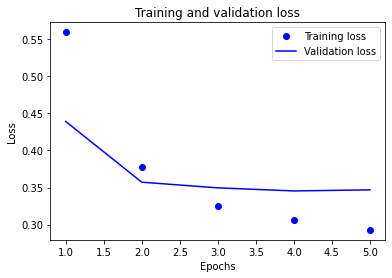

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

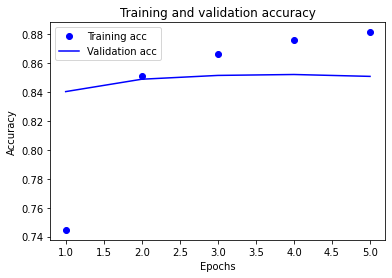

In [18]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
# [[YOUR CODE]]
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 1s 4ms/step - loss: 0.5986 - accuracy: 0.7523 - val_loss: 0.4441 - val_accuracy: 0.8165
Epoch 2/5
227/227 [==============================] - 1s 3ms/step - loss: 0.3853 - accuracy: 0.8346 - val_loss: 0.3622 - val_accuracy: 0.8408
Epoch 3/5
227/227 [==============================] - 1s 3ms/step - loss: 0.3299 - accuracy: 0.8603 - val_loss: 0.3508 - val_accuracy: 0.8467
Epoch 4/5
227/227 [==============================] - 1s 3ms/step - loss: 0.3009 - accuracy: 0.8745 - val_loss: 0.3508 - val_accuracy: 0.8482
Epoch 5/5
227/227 [==============================] - 1s 3ms/step - loss: 0.2797 - accuracy: 0.8851 - val_loss: 0.3552 - val_accuracy: 0.8470


In [21]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3645 - accuracy: 0.8437
[0.36448946595191956, 0.8436641693115234]


In [22]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


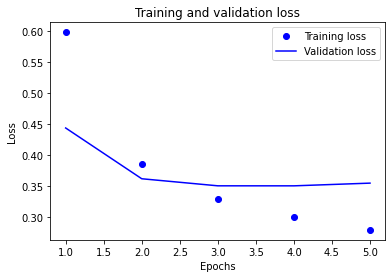

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [25]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['자동차']
vector

array([-0.06233455, -0.02476786, -0.05078606, -0.03695678, -0.04842968,
        0.00129293, -0.01151244, -0.05741524, -0.05289711, -0.05661219,
       -0.0756341 , -0.07321927,  0.0318193 , -0.06326519,  0.02139675,
       -0.02228966], dtype=float32)

In [27]:
word_vectors.similar_by_word("바보")

[('더더욱', 0.930378258228302),
 ('심심', 0.9172828793525696),
 ('데이', 0.9101903438568115),
 ('걸릴', 0.907159149646759),
 ('모니터', 0.8990949988365173),
 ('컴퓨터', 0.8988831043243408),
 ('XX', 0.8980633020401001),
 ('아이고', 0.8912490010261536),
 ('훤히', 0.8875664472579956),
 ('격', 0.8872873783111572)]

In [28]:
from gensim.models import KeyedVectors
import os
import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector     # 무려 300dim의 워드 벡터입니다.

/tmp/ipykernel_5496/256049836.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [29]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("사랑")

/tmp/ipykernel_5496/1098788216.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [31]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_5496/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_5496/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [32]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [34]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
227/227 [==============================] - 15s 9ms/step - loss: 0.5417 - accuracy: 0.7162 - val_loss: 0.4375 - val_accuracy: 0.8006
Epoch 2/4
227/227 [==============================] - 1s 6ms/step - loss: 0.3923 - accuracy: 0.8251 - val_loss: 0.3773 - val_accuracy: 0.8333
Epoch 3/4
227/227 [==============================] - 1s 6ms/step - loss: 0.3302 - accuracy: 0.8590 - val_loss: 0.3593 - val_accuracy: 0.8421
Epoch 4/4
227/227 [==============================] - 1s 6ms/step - loss: 0.2966 - accuracy: 0.8774 - val_loss: 0.3549 - val_accuracy: 0.8455


In [36]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3667 - accuracy: 0.8424
[0.36666375398635864, 0.842382550239563]


epochs 값은 4가 가장 효율적인 반복횟수였다. 오류도 굉장히 많았지만 조원님들의 뛰어난 집단지성으로 성공하였다.
회고를 더 적고싶지만 머리가 터질거같아서 못하겠다..
나중에 회고를 해야겠다